# 흉부 X-ray 이미지로 정상/코로나/폐렴을 분류하는 Image Classification 

데이터 출처: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset

## 1. 이미지 파일경로 불러오기

In [17]:
import os

In [18]:
IMAGE_FORMAT = ['jpeg', 'jpg', 'png']
def list_image_files(data_dir, sub_dir):
    # 모든 이미지들을 리스트 형태로 반환하는 함수 작성
    images_files = [] # 이미지 파일을 받아올 리스트
    # train폴더와 train폴더 하위에 있는 normal, covid, pneunomia에 대한 서브디렉토리로 연결
    images_dir = os.path.join(data_dir, sub_dir)
    
    # 하위 디렉토리에 있는 모든 이미지들을 불러오는 대신에
    # 각 이미지 파일의 확장자를 확인해서 이미지 포맷에 들어있는 확장자 중 하나이면 images_files에 file_path 삽입
    for file_path in os.listdir(images_dir):
        if file_path.split('.')[-1] in IMAGE_FORMAT:
            images_files.append(os.path.join(sub_dir, file_path))
            
    return images_files

In [19]:
data_dir = '../DATASET/Classification/train/'

normal_list = list_image_files(data_dir, 'Normal')
covid_list = list_image_files(data_dir, 'Covid')
pneumonias_list = list_image_files(data_dir, 'Viral Pneumonia')

print(f"Normal: {len(normal_list)}, Covid: {len(covid_list)}, Pneumonia: {len(pneumonias_list)}")

Normal: 70, Covid: 111, Pneumonia: 70


## 2. 이미지 파일을 RGB 3차원 배열로 불러오기

In [20]:
import cv2

In [21]:
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

## 3. 이미지데이터 확인하기

In [22]:
import matplotlib.pyplot as plt
from ipywidgets import interact

In [23]:
# 정상, 코로나, 폐렴의 이미지를 하나의 쌍으로 보기 위해 데이터셋의 길이를 조절
min_num_files = min(len(normal_list), len(covid_list), len(pneumonias_list))
print(min_num_files)

70


In [24]:
# 인터렉티브하게 보일 수 있도록 데코레이터를 사용
@interact(index=(0, min_num_files-1))
def show_samples(index=0):
    # 슬라이드 바가 생성, 바가 0부터 69번까지 이동할 수 있음
    normal_image = get_RGB_image(data_dir, normal_list[index])
    covid_image = get_RGB_image(data_dir, covid_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])
    
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    plt.imshow(normal_image)
    plt.title('Normal')
    
    plt.subplot(132)
    plt.imshow(covid_image)
    plt.title('Covid')
    
    plt.subplot(133)
    plt.imshow(pneumonia_image)
    plt.title('Pneumonia')

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

- 코로나 환자의 폐 사진이 정상 환자나 폐렴 환자의 사진보다 조금 더 뿌연 특징이 있는 것 같다.
- 정상 환자와 폐렴 환자 사이의 구분되는 특징은 없는 것 같다.
    - 이 경우에는 딥러닝 모델이 두가지 케이스에 대해서는 구분하지 못할 확률이 있다.
- 정상과 코로나 환자 사이의 이미지에 대해서는 구분할 수 있는 특징이 있다.
- 각각의 이미지들이 크기가 제각각이다.</br>
  &rarr;  추후에 이미지 resize해줘야 한다.

## 4. 학습데이터셋 클래스 구축

In [25]:
train_data_dir = "../DATASET/Classification/train/"
class_list = ['Normal', 'Covid', 'Viral Pneumonia']

In [26]:
class Chest_dataset():
    def __init__(self, data_dir, transformer=None): # 생성자
        self.data_dir = data_dir
        normals = list_image_files(data_dir, 'Normal')
        covids = list_image_files(data_dir, 'Covid')
        pneumonias = list_image_files(data_dir, 'Viral Pneumonia')
        
        self.files_path = normals + covids + pneumonias
        self.transformer = transformer
        # 나중에 이미지를 텐서형태로 변환하고
        # 그 외에 augmentation기법을 적용할 때 트랜스포머로 많은 인스턴스를 전달하는 편
    
    def __len__(self): # 데이터셋의 길이
        return len(self.files_path)
    
    def __getitem__(self, index): # 데이터셋에 호출되는 인덱스에 맞는 아이템을 리턴
        image_file = os.path.join(self.data_dir, self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        '''
        print(self.data_dir)
        print(self.files_path[index])
        print(self.files_path[index].split(os.sep)[0])
        '''
        class_name = self.files_path[index].split(os.sep)[0]
        #print(class_name)
        class_id = class_list.index(class_name)
        #print(class_id)
        
        if self.transformer:
            image = self.transformer(image)
            class_id = torch.Tensor([class_id]).long() # 텐서형으로 바꾸고 long=인트 값으로 변환
            
        return image, class_id

In [27]:
dset = Chest_dataset(data_dir = train_data_dir)

In [28]:
index = -10
image, target = dset[index]

In [29]:
print(image.shape)
print(target)

(1416, 1960, 3)
2


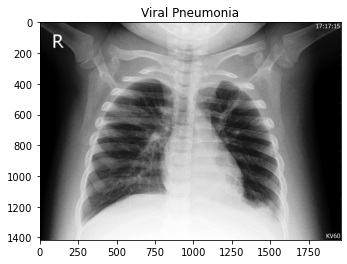

In [30]:
# 인덱스 값을 토대로 시각화하기
plt.title(class_list[target])
plt.imshow(image)

In [31]:
len(dset)

251

## 5. 연산가능한 텐서형으로 데이터 변환하기

In [32]:
import torch
from torchvision import transforms

In [33]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [34]:
train_dset = Chest_dataset(train_data_dir, transformer)
index = 200
image = train_dset[index][0]
target = train_dset[index][1]
print(image.shape)
print(target)

torch.Size([3, 224, 224])
tensor([2])


In [35]:
image

tensor([[[-0.8034, -0.7613, -0.6594,  ..., -0.9770, -0.9105, -0.9532],
         [-0.7853, -0.6306, -0.6515,  ..., -0.9492, -0.9707, -0.9649],
         [-0.7271, -0.6258, -0.6338,  ..., -0.9922, -0.9843, -0.9857],
         ...,
         [-0.8902, -0.8902, -0.8980,  ..., -0.9137, -0.9137, -0.9137],
         [-0.8902, -0.8902, -0.8980,  ..., -0.9137, -0.9137, -0.9137],
         [-0.8902, -0.8902, -0.8980,  ..., -0.9137, -0.9137, -0.9137]],

        [[-0.8034, -0.7613, -0.6594,  ..., -0.9770, -0.9105, -0.9532],
         [-0.7853, -0.6306, -0.6515,  ..., -0.9492, -0.9707, -0.9649],
         [-0.7271, -0.6258, -0.6338,  ..., -0.9922, -0.9843, -0.9857],
         ...,
         [-0.8902, -0.8902, -0.8980,  ..., -0.9137, -0.9137, -0.9137],
         [-0.8902, -0.8902, -0.8980,  ..., -0.9137, -0.9137, -0.9137],
         [-0.8902, -0.8902, -0.8980,  ..., -0.9137, -0.9137, -0.9137]],

        [[-0.8034, -0.7613, -0.6594,  ..., -0.9770, -0.9105, -0.9532],
         [-0.7853, -0.6306, -0.6515,  ..., -0

## 6. 데이터로더 구현하기

In [36]:
from torch.utils.data import DataLoader

In [37]:
train_data_dir = "../DATASET/Classification/train/"
val_data_dir = "../DATASET/Classification/test/"

train_dset = Chest_dataset(train_data_dir, transformer)
train_dloader = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)
# 전체 데이터 수가 9개이면 batch가 4개 일때 마지막 데이터가 남는데 drop_last로 마지막 데이터 drop함

val_dset = Chest_dataset(val_data_dir, transformer)
val_dloader = DataLoader(val_dset, batch_size=1, shuffle=False)
# validation은 batch를 크게 묶어도 혹은 작게 묶어도 상관이 없고 학습에 전혀 영향을 미치지 않는 것이기 때문에
# 배치 크기를 1로 하고 shuffle도 꺼버림

In [38]:
def build_dataloader(train_data_dir, val_data_dir):
    # 함수 구현해서 dataloader를 만들기도 함. 위의 코드와 동일
    dataloaders = {}
    train_dset = Chest_dataset(train_data_dir, transformer)
    dataloaders['train'] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)

    val_dset = Chest_dataset(val_data_dir, transformer)
    dataloaders["val"] = DataLoader(val_dset, batch_size=1, shuffle=False)
    
    return dataloaders

In [39]:
train_data_dir = "../DATASET/Classification/train/"
val_data_dir = "../DATASET/Classification/test/"

dataloaders = build_dataloader(train_data_dir, val_data_dir)
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fb4b32671c0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fb4b193d880>}


## 7. Classification 모델(VGG19) 불러오기

In [40]:
from torchvision import models

In [41]:
model = models.vgg19(pretrained=True)

/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
from torchsummary import summary

summary(model, (3, 244, 244), batch_size=1, device='cpu')

ModuleNotFoundError: No module named 'torchsummary'

In [43]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## 8. 데이터에 맞도록 모델 Head 부분 변경하기

In [44]:
import torch.nn as nn
# torch.nn 은 레이어를 작성하고 혹은 작성한 레이어들을 하나의 sequential한 어떤 아키텍쳐로 구성할 수 있게 하는 모듈

In [45]:
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
# AdaptiveAvgPooling 레이어는 기존의 풀링레이어와 다르게 아웃풋 사이즈를 지정을 하면 어떤 입력값이 와도 지정한 아웃풋 사이즈로 데이터 풀링을 수행

In [46]:
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 3),
)

In [47]:
def build_vgg19_based_model(device='cpu'):
    # 위에 변경한 부분을 하나의 함수로 만듬
    device = torch.device(device)
    model = models.vgg19(pretrained=True)
    
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 3),
        nn.Softmax(dim=1)
    )
    
    return model.to(device)

In [48]:
model = build_vgg19_based_model(device='cpu')

In [49]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## 9. 손실함수(Cross-Entropy) 불러오기

In [50]:
loss_func = nn.CrossEntropyLoss(reduction='mean')

## 10. SGDM 최적화 기법 적용하기

* Stochastic Gradient Descent with Momentum(SGDM) Optimization

In [51]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 11. 모델 학습을 위한 함수 구현하기

In [52]:
device = torch.device("cpu")

In [53]:
# train을 위한 함수
def train_one_epoch(dataloaders, model, optimizer, loss_function, device):
    loss = {}
    
    for phase in ["train", "val"]:
        running_loss = 0.0
        # train이나 val 모드에서 running_loss를 중간중간 맏아와서 프린트문 외부에 찍히게 되서
        # 실제로 잘 학습하고 있는지, loss 가 잘 줄어들고 있는지를 확인할 수 있게 변수 설정

        if phase == "train":
            model.train()
        else:
            model.eval()
            
        for index, batch in enumerate(dataloaders[phase]):
            image = batch[0].to(device) # 첫번째 리턴값: 이미지
            label = batch[1].to(device) # 두번째 리턴값: 클래스 아이디
            
            with torch.set_grad_enabled(phase == "train"):
                prediction = model(image)
                loss = loss_func(prediction, target)
                
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item()
                
                if phase == "train":
                    if index % 10 == 0:
                        print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
                        
            losses[phase] = running_loss / len(dataloaders[phase])
            
        return losses

## 12. 모델 검증을 위한 Accuracy 생성하기

* Top-1 accuracy
    * 가장 confidence가 높은 예측값의 클래스가 ground truth 와 일치하는 경우 True-Positive 로 판단
* Top-5 accuracy
    * confidence가 높은 상위 5개 예측값의 클래스에 ground truth 가 존재하는 경우 True-Positive로 판단

In [54]:
# accuracy를 구할땐 backward가 필요없기 때문에 decorator 써주기
@torch.no_grad()
def get_accuracy(image, target, model):
    batch_size = image.shape[0]
    prediction = model(image) # (B, NUM_CLASSES)
    _, pred_label = torch.max(prediction, dim=1)
    is_correct = (pred_label == target) # True or False
    accuracy = is_correct.cpu().numpy().sum() / batch_size
    return accuracy

## 13. 모델 학습 수행하기

In [55]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [56]:
train_data_dir = "../DATASET/Classification/train/"
val_data_dir = "../DATASET/Classification/test/"
dataloaders = build_dataloader(train_data_dir, val_data_dir)
model = build_vgg19_based_model(device=device)
loss_func = nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [57]:
def train_one_epoch(dataloaders, model, optimizer, loss_function, device):
    losses = {}
    accuracies = {}
    
    for phase in ["train", "val"]:
        running_loss = 0.0
        running_correct = 0.0 # 매번 트레인과 밸리데이션 페이지별로 accuracy도 누적시킴

        if phase == "train":
            model.train()
        else:
            model.eval()
            
        for index, batch in enumerate(dataloaders[phase]):
            image = batch[0].to(device) # 첫번째 리턴값: 이미지
            label = batch[1].squeeze(dim=1).to(device) # 두번째 리턴값: 클래스 아이디
            
            with torch.set_grad_enabled(phase == "train"):
                prediction = model(image)
                loss = loss_func(prediction, label)

                optimizer.zero_grad()
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image, label, model)
                
            if phase == "train":
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
                        
        losses[phase] = running_loss / len(dataloaders[phase])
        accuracies[phase] = running_correct / len(dataloaders[phase])
            
    return losses, accuracies

In [58]:
num_epochs = 10

best_acc = 0.0
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    train_loss.append(losses['train'])
    train_acc.append(accuracies['train'])
    val_loss.append(losses['val'])
    val_acc.append(accuracies['val'])
    
    print(f"{epoch}/{num_epochs}-Tr loss:{losses['train']}, Val loss {losses['val']}")
    print(f"{epoch}/{num_epochs}-Tr acc:{accuracies['train']}, Val acc {accuracies['val']}")
    
    if accuracies["val"] > best_acc:
        best_acc = accuracies['val']
        torch.save(model.state_dict(), f"model_{epoch}.pth")

0/62 - Running loss: 1.1019707918167114
10/62 - Running loss: 1.1041345596313477
20/62 - Running loss: 1.0686455965042114
30/62 - Running loss: 1.0278284549713135
40/62 - Running loss: 1.0175187587738037
50/62 - Running loss: 1.018444299697876
60/62 - Running loss: 0.899133563041687
0/10-Tr loss:1.0470818185037183, Val loss 0.8947428085587241
0/10-Tr acc:0.4879032258064516, Val acc 0.696969696969697
0/62 - Running loss: 0.8792086839675903
10/62 - Running loss: 0.9998327493667603
20/62 - Running loss: 0.7961724400520325
30/62 - Running loss: 0.9565675854682922
40/62 - Running loss: 0.9340616464614868
50/62 - Running loss: 0.6317038536071777
60/62 - Running loss: 0.7119137048721313
1/10-Tr loss:0.9001054484998027, Val loss 0.7988966902097067
1/10-Tr acc:0.6854838709677419, Val acc 0.7272727272727273
0/62 - Running loss: 0.698165237903595
10/62 - Running loss: 0.6792811751365662
20/62 - Running loss: 1.2637193202972412
30/62 - Running loss: 0.8014447689056396
40/62 - Running loss: 0.55144

## 14. 테스트 이미지를 통한 학습모델 분류성능검증하기

In [59]:
data_dir = "../DATASET/Classification/test/"
class_list = ["Normal", "Covid", "Viral Pneumonia"]

test_normals_list = list_image_files(data_dir, "Normal")
test_covids_list = list_image_files(data_dir, "Covid")
test_pneumonias_list = list_image_files(data_dir, "Viral Pneumonia")

In [63]:
def preprocess_image(image):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    tensor_image = transformer(image) # (C, H, W)
    tensor_image = tensor_image.unsqueeze(dim=0) # (B, C, H, W)    
    return tensor_image

In [65]:
@torch.no_grad()
def model_predict(image, model):
    tensor_image = preprocess_image(image)
    prediction = model(tensor_image)
    _, pred_label = torch.max(prediction.detach().cpu(), dim=1) #(B, NUM_CLASSES)
    pred_label = pred_label.squeeze(dim=0)
    return pred_label.item() # 토치 변수가 가지고 있는 수치적인 값만을 가져옴

In [66]:
ckpt = torch.load("./trained_model/model_06.pth")

model = build_vgg19_based_model(device='cpu')
model.load_state_dict(ckpt)
model.eval()

/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [68]:
min_num_files = min(len(test_normals_list), len(test_covids_list), len(test_pneumonias_list))

@interact(index=(0, min_num_files-1))
def show_result(index=0):
    normal_image = get_RGB_image(data_dir, test_normals_list[index])
    covid_image = get_RGB_image(data_dir, test_covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, test_pneumonias_list[index])
    
    pred_normal = model_predict(normal_image, model)
    pred_covid = model_predict(covid_image, model)
    pred_pneumonia = model_predict(pneumonia_image, model)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title(f"Pred:{class_list[pred_normal]} | GT:Normal")
    plt.imshow(normal_image)
    
    plt.subplot(132)
    plt.title(f"Pred:{class_list[pred_covid]} | GT:Covid")
    plt.imshow(covid_image)
    
    plt.subplot(133)
    plt.title(f"Pred:{class_list[pred_pneumonia]} | GT:Viral Pneumonia")
    plt.imshow(pneumonia_image)

interactive(children=(IntSlider(value=0, description='index', max=19), Output()), _dom_classes=('widget-intera…